# Isochrones for a cluster using PopStar

In [31]:
using PyCall

## PopStar modules...
synthetic= pyimport("popstar.synthetic")
evolution= pyimport("popstar.evolution")
atmospheres= pyimport("popstar.atmospheres")
reddening= pyimport("popstar.reddening")

using Distributions
using Statistics
using DataFrames
using Distances
using Random , Printf

rootdir = ENV["GAIA_ROOT"]
push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

import PyPlot , CSV

wdir    = "$rootdir/products"
votdir  = "$rootdir/products/votable"
ocdir   = "$rootdir/products/oc2"

cd(wdir)

In [32]:
#ocfile= "ASCC 23-1.9deg-oc.csv"
 ocfile= "NGC 2516-3.5deg-oc.csv"
# ocfile= "NGC 2632-15.5deg-oc.csv"
# ocfile= "NGC 6475-3.5deg-oc.csv"
# ocfile= "NGC 2318-1.0deg-oc.csv"
df= CSV.read("$ocdir/$ocfile", delim= ";")

agmedian= median(df.ag[.! isnan.(df.ag)])
distance= median(df.distance)

# Define isochrone parameters
logAge = 8.47  # Age in log(years)
AKs = agmedian # extinction in mags
AKs= 0.00
dist = distance # distance in parsec
metallicity = 0.0 # Metallicity in [M/H]


println("log Age: $logAge")
println("AKs: $AKs")
println("distance: $dist")
println("metallicity: $metallicity")

log Age: 8.47
AKs: 0.0
distance: 413.81886990819356
metallicity: 0.0


In [33]:
## Define evolution/atmosphere models and extinction law
evo_model = evolution.MergedBaraffePisaEkstromParsec() 
#evo_model= evolution.MISTv1()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()

## Filter
filt_list = [ "gaia,dr2_rev,Gbp", "gaia,dr2_rev,G"  ,"gaia,dr2_rev,Grp"]
#filt_list= ["ubv,V", "ubv,B", "ubv,R"]
#filt_list = ["wfc3,ir,f127m", "wfc3,ir,f139m", "wfc3,ir,f153m"]

iso = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list)

#println(keys(iso))

data= iso.points
println(data.keys())
ndata= size(data)[1]

mass= zeros(ndata)
Gmag= zeros(ndata)
BPmag= zeros(ndata)
RPmag= zeros(ndata)
color= zeros(ndata)

for i in 1:ndata
    mass[i]= data[i][4]
    Gmag[i]= data[i][10]
    BPmag[i]= data[i][9]
    RPmag[i]= data[i][11]
    color[i]= BPmag[i]-RPmag[i]
end

## Cluster
BmR= df.bp .- df.rp
GMAG= df.gbar + 5 .* log10.(df.distance) .- 17.


println("## done")

["L", "Teff", "R", "mass", "logg", "isWR", "mass_current", "phase", "m_hst_Gbp", "m_hst_G", "m_hst_Grp"]


┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = top-level scope at In[33]:29
└ @ Core ./In[33]:29
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = top-level scope at In[33]:29
└ @ Core ./In[33]:29
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = top-level scope at In[33]:30
└ @ Core ./In[33]:30
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = top-level scope at In[33]:30
└ @ Core ./In[33]:30
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = top-level scope at In[33]:31
└ @ Core ./In[33]:31
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = top-level scope at In[33]:31
└ @ Core ./In[33]:31
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i 

## done


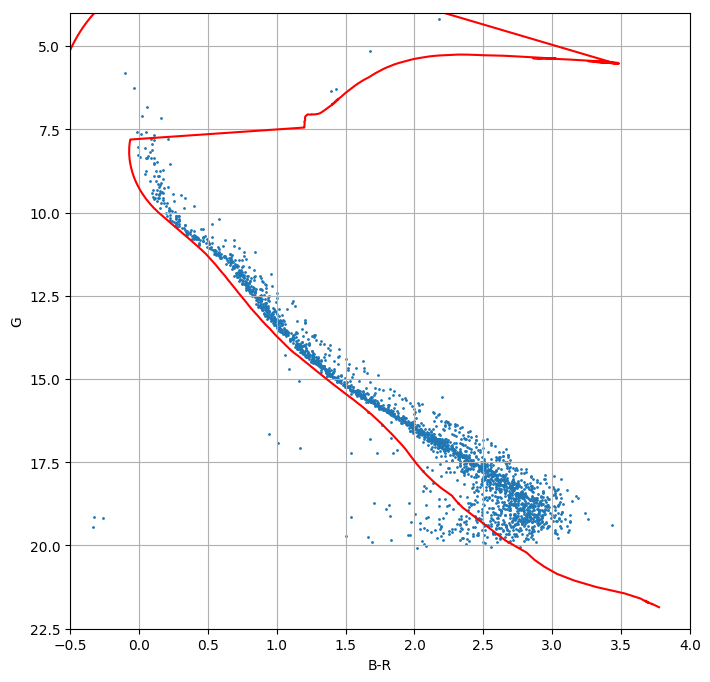

In [34]:
### plots the CMD and isochrones

fig= PyPlot.figure(figsize=(8,8))

ax = PyPlot.subplot(111)
PyPlot.grid("on")

PyPlot.xlim(-0.5,4)
PyPlot.ylim(22.5,4)
PyPlot.scatter(BmR, GMAG, s=1)
PyPlot.plot( BPmag .- RPmag, Gmag, "r-")

# PyPlot.plot(iso["points"][:][10] .- iso.points[:][11], iso.points[:][9], "r-")
PyPlot.ylabel("G")
PyPlot.xlabel("B-R")
PyPlot.show()

## Compute the stellar mass from the isochrone

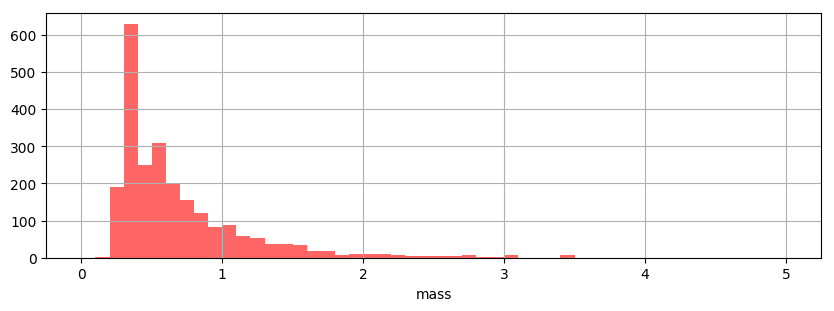

In [35]:
nxy= length(mass)
A= Array{Float64}(undef,2,nxy)
for i in 1:nxy
    A[1,i]= color[i]
    A[2,i]= Gmag[i]
end
    
d= Distances.Euclidean()

mstar= zeros(length(BmR))

for i in 1:length(BmR)
    starm= [BmR[i]; GMAG[i]]
    r= Distances.colwise(d, A, starm)
    
    idx= argmin(r)
    mstar[i]= mass[idx]
end

## plot
fig = PyPlot.figure(figsize=(10,7))

ax = PyPlot.subplot(211)
PyPlot.grid("on")
nbins = 50
h = PyPlot.hist(mstar, nbins, range = [0,5], color = "r", alpha=0.6 , label = "mass")
PyPlot.xlabel("mass")

PyPlot.show()